In [0]:
#@title Import Libraries
"""Import the necessary libraries"""

import os
import glob
import numpy as np
import pandas as pd
from sklearn import decomposition
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
!pip install -q python-ternary   #Used to plot phase diagrams
import ternary
from scipy.stats import norm, multivariate_normal
import scipy.signal as ss
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

!pip install -q git+https://github.com/saimani5/GPim.git --upgrade
from gpim import gprutils, gpr

In [0]:
#@title Download necessary files

!gdown --id 10JprGI_3Tcf-m08Pgz24RbUumuw030ph
!gdown --id 1kMoKIDgz681ucKFPSR_FyVf6tSsc6MCR

#data file with PL data
file_tobe_read = '03.11.2020 - MAPbBr3, FAPbbr3 and CsPbbr3 - Luminescence.csv'
#lables datafile denoting the concentrations of precurssors in each well
ternary_lables = pd.read_csv('03.11.2020 - MAPbBr3, FAPbBr3 and CsPbBr3 - Compositions.csv')

Downloading...
From: https://drive.google.com/uc?id=10JprGI_3Tcf-m08Pgz24RbUumuw030ph
To: /content/03.11.2020 - MAPbBr3, FAPbbr3 and CsPbbr3 - Luminescence.csv
100% 741k/741k [00:00<00:00, 48.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kMoKIDgz681ucKFPSR_FyVf6tSsc6MCR
To: /content/03.11.2020 - MAPbBr3, FAPbBr3 and CsPbBr3 - Compositions.csv
100% 1.11k/1.11k [00:00<00:00, 2.08MB/s]


In [0]:
#@title Functions used for analysis
def read_data(file_tobe_read, num_of_reads, cells, scan):
  """
  Reads data from the csv file and stores it into a dictionary
  Input:
          file_tobe_read: Name of the csv file with PL dataset 
          num_of_reads:
     Output:
          d: dictionary in the form A(x,y,w,t)
  """



  rawData = pd.read_csv(file_tobe_read, header=None)
  rawData = rawData.replace('OVRFLW', np.NaN)



  rows = []
  for i in range(1, num_of_reads + 1):
      rows += rawData[rawData[rawData.columns[0]] == 'Read ' + str(i) + ':EM Spectrum'].index.tolist()
  rows += rawData[rawData[rawData.columns[0]] == 'Results'].index.tolist()

  names = []

  for i in range(1, num_of_reads + 1):
    names.append('Read ' + str(i))


  d = {}

  for c in names:
    split_name = c.split(' ')
    index = int(split_name[1])
    d[c] = rawData[rows[index - 1] + 2 :rows[index] - 1] #Take a section of the values 
    d[c] = d[c].drop([0], axis = 1) #Drop the empty column
    new_header = d[c].iloc[0] #grab the first row for the header
    d[c] = d[c][1:] #take the data less the header row
    d[c].columns = new_header #set the header row as the df header
    d[c] = d[c].astype(float) #Make sure that it is composed of numbers


  wavelength = d['Read '+ str(1)]['Wavelength']
  nx,ny = np.meshgrid(wavelength, scan) 
  data_initial_df = pd.DataFrame()

  for i,scan_num in enumerate(scan):
    data_initial_df = data_initial_df.append(d['Read ' +str(scan_num)])
  data_initial_df.insert(loc = 0, column = 'scan', value = ny.ravel())


  data_initial_df_inter = data_initial_df.interpolate(method='cubic', axis=0, limit_direction = 'both', limit_area = 'inside')


  data_final_df_filled = data_initial_df_inter.fillna(0.0)
  data_final_dropped = data_final_df_filled.drop(cells_no_data, axis = 1)

  data_final_vec = np.array(data_final_dropped)
  return d,data_final_dropped,data_final_vec



def do_decomposition(dataset, decomposition_to_be_done = 'NMF', n_comp=3):
  if decomposition_to_be_done == 'PCA':
    decompos = decomposition.PCA(n_components=n_comp)

  if decomposition_to_be_done == 'NMF':
    decompos = decomposition.NMF(n_components=n_comp)

  data_final_vec_t = decompos.fit_transform(dataset[:,2:])

  if decomposition_to_be_done == 'PCA':
    explained_var = decompos.explained_variance_ratio_
    plt.plot(explained_var)

  components = decompos.components_

  print('Loading maps')
  figure, axes = plt.subplots(nrows = 1, ncols = n_comp, figsize = (25,4))
  for j in range(n_comp):
    dict_phase = {}
    for i in range(len(A)):
      dict_phase[(A[i],B[i],C[i])] = components[j,i]
    
    if interpolation:
      dict_phase_interpolated,_ = GPinterpolation(dict_phase)
      dict_phase = dict_phase_interpolated
      scale = 100
    
    else:
      scale = 12.5
    
    figure, tax = ternary.figure(scale=scale, ax = axes[j])
    tax.heatmap(dict_phase,  style="hexagonal")
    tax.boundary(linewidth=2.0)
    tax.right_corner_label("A", fontsize=14, offset = 0.1)
    tax.top_corner_label("B", fontsize=14, offset = 0.2)
    tax.left_corner_label("C", fontsize=14, offset = 0.1)
    fontsize = 12
    tax.ticks(axis='blr', linewidth=1, offset=0.035, multiple = scale/5)
    tax.set_title("loading map compnent_%0.0f\n"%(j+1), fontsize = 12)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    


  print('Plotting eigen vectors')

  fig,ax = plt.subplots(nrows = 1, ncols = n_comp, figsize = (25,4))
  for i in range(n_comp):
    ax[i].imshow(data_final_vec_t[:,i].reshape([scan_steps, lambda_steps]))
    ax[i].invert_yaxis()
    ax[i].set_xlabel('wavelength')
    ax[i].set_xticks(np.arange(0,lambda_steps,10))
    ax[i].set_xticklabels(wavelength[0::10], fontsize=10)
    ax[i].set_yticks(np.arange(0,scan_steps,10))
    ax[i].set_yticklabels(time[0::10], fontsize=10)
    ax[i].set_ylabel('time (minutes)')


def GPinterpolation(working_dict):
  """Input: A dictionary with sparse datapoints
  Output: 
  dict_phase_extrapolated: Interpolated dictionary and
  dict_phase_uncertainty: Uncertainty of interpolation
  """
  Z_sparse = np.empty(shape = [101,101])
  Z_sparse[:] = np.nan

  for key, value in working_dict.items():
    aa, bb, _ = key
    Z_sparse[int(round(aa*8)), int(round(bb*8))] = value



  grid_density = 1
  X = gprutils.get_sparse_grid(Z_sparse)
  Xtest = gprutils.get_full_grid(Z_sparse, dense_x=(1/grid_density))
  lscale = [1., 60.] # [min, max]

  # Run GP reconstruction
  recon = gpr.reconstructor(
      X, Z_sparse, Xtest, kernel='RBF', indpoints=len(Z_sparse.flatten())//2,
      learning_rate=0.01, iterations=700, lengthscale=lscale,
      use_gpu=False, verbose=False, calculate_sd=True, patience = 40)

  mean, sd, hyperparams = recon.run()

  dict_phase_extrapolated = {}
  dict_phase_uncertainty = {}

  for i in range(0, 101):
    for j in range(0, 101):
      local_value = mean.reshape(Z_sparse.shape[0]*grid_density, Z_sparse.shape[1]*grid_density)[i,j]
      k = int(100-i-j)
      if (k >= 0):
        dict_phase_extrapolated.update({(i, j, k): local_value})

  for i in range(0, 101):
    for j in range(0, 101):
      local_value = sd.reshape(Z_sparse.shape[0]*grid_density, Z_sparse.shape[1]*grid_density)[i,j]
      k = 100-i-j
      if (k >= 0):
        dict_phase_uncertainty.update({(i, j, k): local_value})

  return dict_phase_extrapolated, dict_phase_uncertainty

In [0]:
#@title User Inputs 

num_of_reads = 59    #@param {type:"integer"}

#Number of minutes for each scan (minutes)
time_step = 5.0      #@param {type:"number"}

# Number of peaks (1.0 or 2.0) to be considered in the analysis
peaks_to_consider = 1   #@param {type:"integer"} 

#Analysis to be performed
decomposition_to_be_done = 'NMF'  #@param {type:"string"}

# Number of components for dimensionality reduction
n_comp = 3      #@param {type:"integer"}

#Whether to interpolate ternary phase diagrams
interpolation = True    #@param {type:"string"}

luminescence_read_numbers = '2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,37,39,41,43,45,47,49,51,53,55,57,59' #@param {type:"string"}

scans = np.array(list(luminescence_read_numbers.split(","))).astype(int)
scan_total = np.arange(1,num_of_reads)
scan_steps = len(scans)
time = scans*time_step
time_steps = len(time)

cells = []
for i in range(1, 9):
  for j in range(1 , 13): 
    cells.append(chr(64 + i) + str(j))

In [0]:
#@title Preprocessing of lables data
"""Stuff for ternary phase diagrams"""
A = []
B = []
C = []
cells_no_data = []

no_data = np.zeros(len(cells), dtype = bool)
for j,cell_name in enumerate(cells):
  composition = ternary_lables[cell_name]
  if (composition==0.0).all():
    cells_no_data.append(cell_name)
    no_data[j] = True
  else:
    A.append(composition[0]/4)
    B.append(composition[1]/4)
    C.append(composition[2]/4)

index = np.linspace(0,95,96)
index_drop = index[~no_data]
cells_cons = list(np.array(cells)[~no_data])
#print(index_drop)

In [0]:
"""Reading data from csv file"""
d,data_final_dropped,data_final_vec = read_data(file_tobe_read, num_of_reads,cells, scans)

In [0]:
#@title Obtaining file specific constants
"""Let's get the file specific constants here (about the wavelength limits and its Discretization)"""
j = 0
i = 1
wavelength = d['Read '+ str(i)]['Wavelength']
lambda_min = np.amin(wavelength)
lambda_max = np.amax(wavelength)
lambda_steps = len(wavelength)

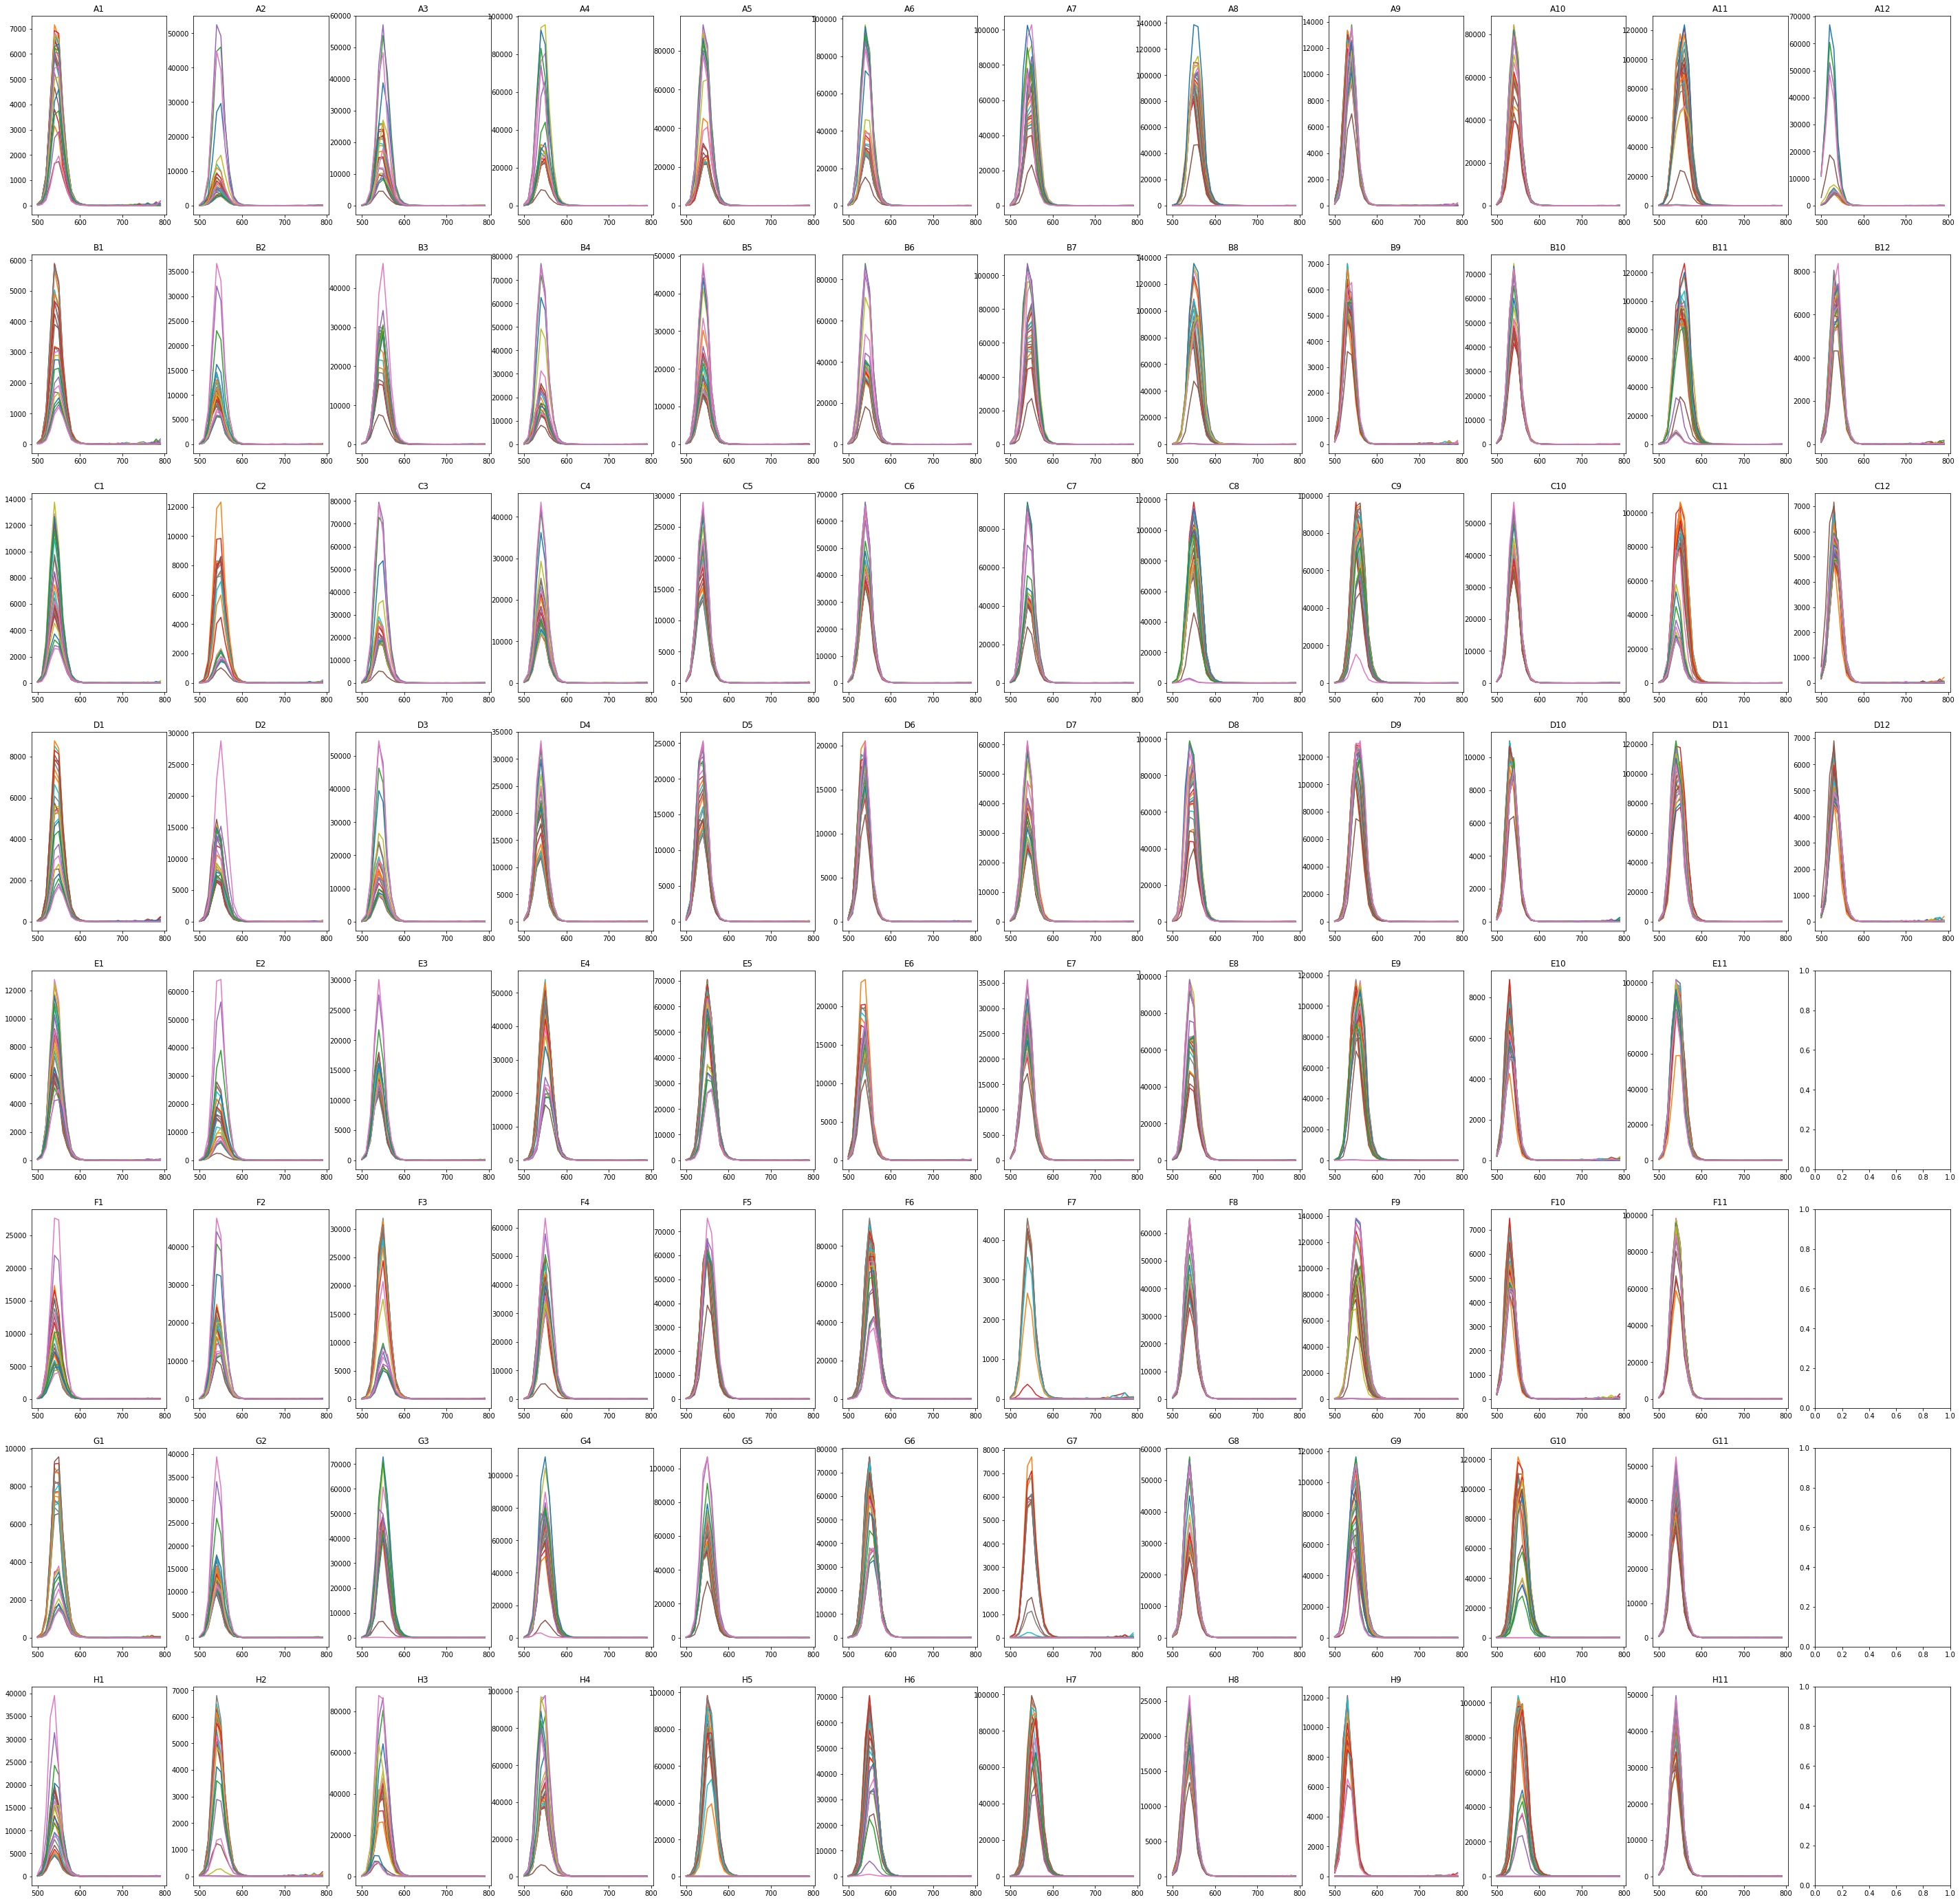

In [0]:
#@title Plot PL data
"""Plot stuff here (i corresponds to time series, where j and cells correspond to different compositions)"""

fig, axes = plt.subplots(nrows = 8, ncols = 12, figsize = (50,50))
for j, num in enumerate(index_drop):
  for i in range (1,len(d)):

    # d['Read '+ str(i)].plot(x = 'Wavelength', y = cells[j],ax = axes[int(j/12), int(j%12)], title = str(cells[j]), legend = False)
    data_cons = data_final_dropped[data_final_dropped['scan'] == i]
    axes[int(num/12), int(num%12)].plot(data_cons['Wavelength'],data_cons[cells[int(num)]])
    axes[int(num/12), int(num%12)].set_title(str(cells[int(num)]))

# Whole data analysis (without peak finding)

We are doing two distinct types of normalizations. Each one should extract different set of features.

Type-1: Scaling the whole dataset to [0,1]. This will preserve the scale of the peaks corresponding to different Wells. When clustered together compositions with generally higher peaks form a cluster.

Loading maps
Plotting eigen vectors


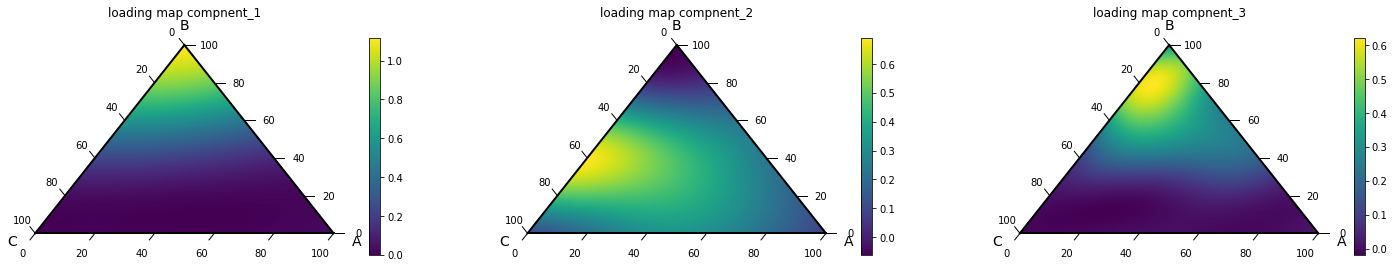

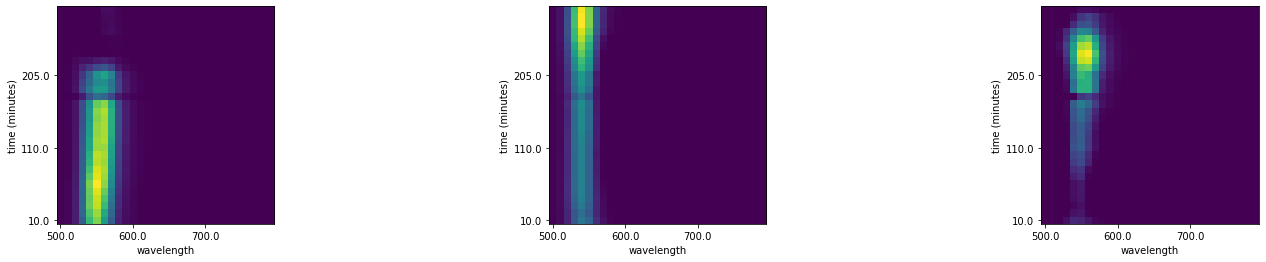

In [0]:
data_final_vec_norm_1 = (data_final_vec - np.amin(data_final_vec))/(np.amax(data_final_vec) - np.amin(data_final_vec))
do_decomposition(dataset = data_final_vec_norm_1, decomposition_to_be_done = 'NMF', n_comp=3)

Type-2: Scaling the peaks of each well to [0,1]. The maximum intensity of any well would be 1. This will destroy the relative intensities of the peaks corresponding to different compositions. This type of normalization would put more emphasis om the trends of peaks in time (whether they increase or decrease in intensity OR move on wavelength axis).

Loading maps
Plotting eigen vectors


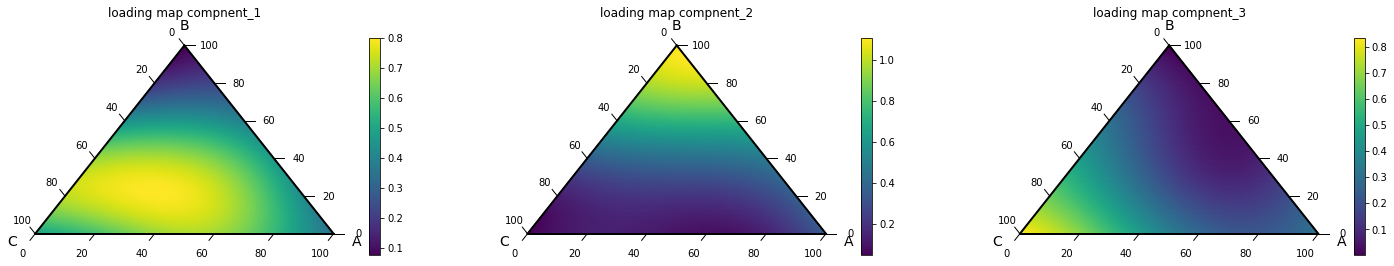

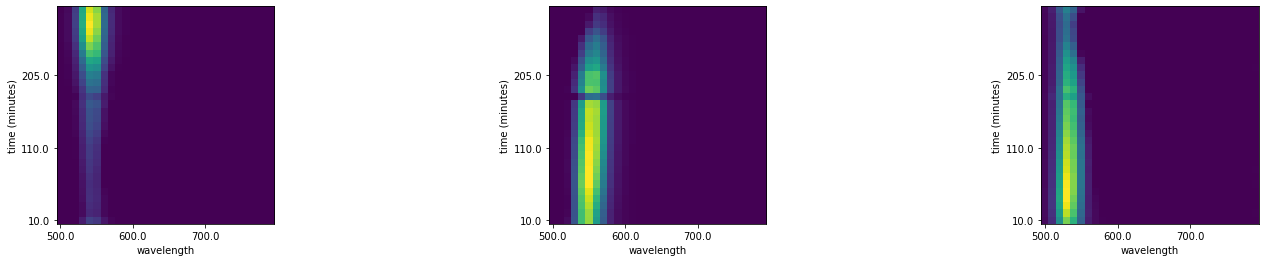

In [0]:
scaler = MinMaxScaler()
data_final_vec_norm_2 = scaler.fit_transform(data_final_vec)

do_decomposition(dataset = data_final_vec_norm_2, decomposition_to_be_done = 'NMF', n_comp=3)